This notebook provides demo on the prediction made by the Qwen2-2B-VL and the Florence 2 model on the Med-VQA test set.

In [ ]:
# !pip install -U -q git+https://github.com/huggingface/trl.git bitsandbytes peft qwen-vl-utils trackio
# pip install evaluate nltk rouge_score bert_score

In [ ]:
from datasets import load_dataset
from IPython.display import display
from tqdm import tqdm
import nltk
import evaluate

import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
import matplotlib.pyplot as plt

/home/triho/Data/miniconda3/envs/nlpmedvqa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Load dataset

In [4]:
train_dataset, eval_dataset, test_dataset = load_dataset("SonicNLP/medvqa_dataset", split=['train', 'validation', 'test'])
print(train_dataset)
print(eval_dataset)
print(test_dataset)

Dataset({
    features: ['id', 'image', 'question', 'answers'],
    num_rows: 12792
})
Dataset({
    features: ['id', 'image', 'question', 'answers'],
    num_rows: 2000
})
Dataset({
    features: ['id', 'image', 'question', 'answers'],
    num_rows: 500
})


In [17]:
def visualize_vqa_sample(image, question, prediction, ground_truth):
    """
    Visualize a VQA sample.
    
    Parameters:
    - image (str): The PIL Image.
    - question (str): The VQA query/question.
    - prediction (str): The model's predicted answer.
    - ground_truth (str): The ground truth answer.
    """

    # Load image

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image.resize((256, 256)))
    ax.axis('off')  # Hide axes

    # Display the question, prediction, and ground truth as a text box
    textbox = f"Question: {question}\nPrediction: {prediction}\nGround Truth: {ground_truth}"
    
    # Add textbox as annotation
    plt.gcf().text(0.5, 0.05, textbox, fontsize=12, ha='center', va='center',
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.tight_layout()
    plt.show()

## 2. Qwen2-2B-VL prediction

In [6]:
qwen_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "/data/triho/NLP_VQA/qwen2-2b-MedVQA-2",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [7]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from medical images.
Your task is to analyze the provided medical image and respond to queries with concise answers, usually a single word, number, or short phrase.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

def format_data(sample):
    return {
      "images": [sample["image"].resize((256, 256))],
      "messages": [
          {
              "role": "system",
              "content": [
                  {
                      "type": "text",
                      "text": system_message
                  }
              ],
          },
          {
              "role": "user",
              "content": [
                  {
                      "type": "image",
                      "image": sample["image"],
                  },
                  {
                      "type": "text",
                      "text": sample['question'],
                  }
              ],
          },
          {
              "role": "assistant",
              "content": [
                  {
                      "type": "text",
                      "text": sample["answers"][0]
                  }
              ],
          },
      ]
      }

def qwen_vqa_prediction(model, processor, sample, max_new_tokens=1024, device="cuda"):
    sample = format_data(sample)
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        # sample['messages'][1:2],  # Use the sample without the system message
        sample['messages'][:2],
        tokenize=False,
        add_generation_prompt=True
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample['messages'])

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

Do prediction

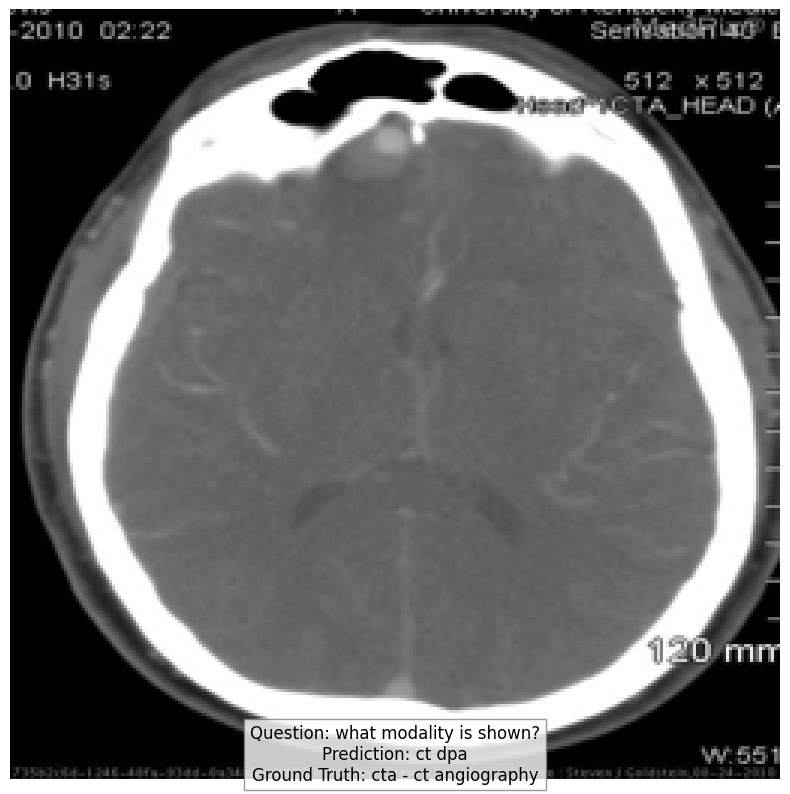

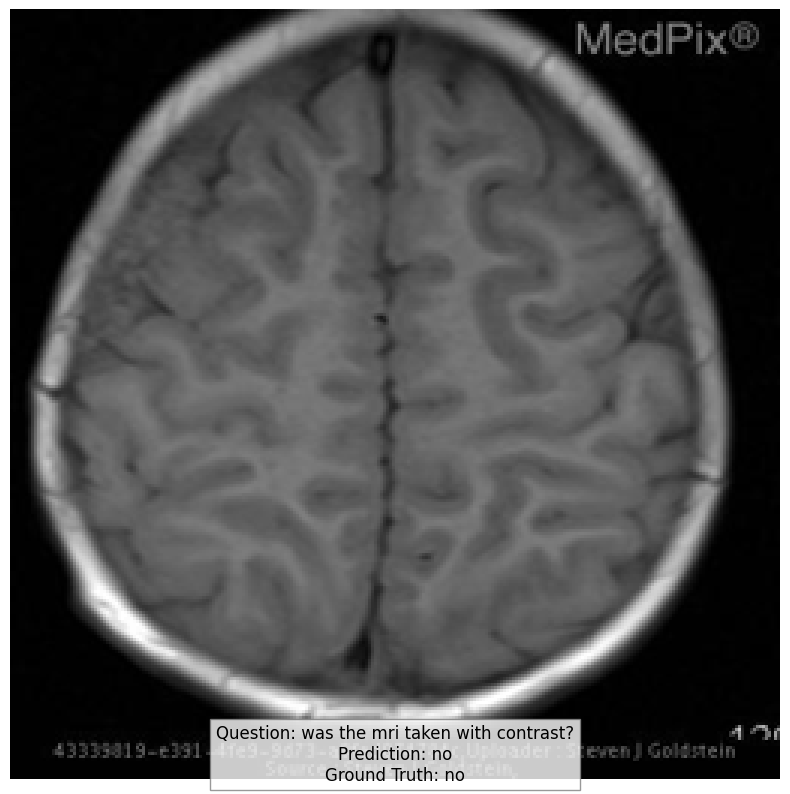

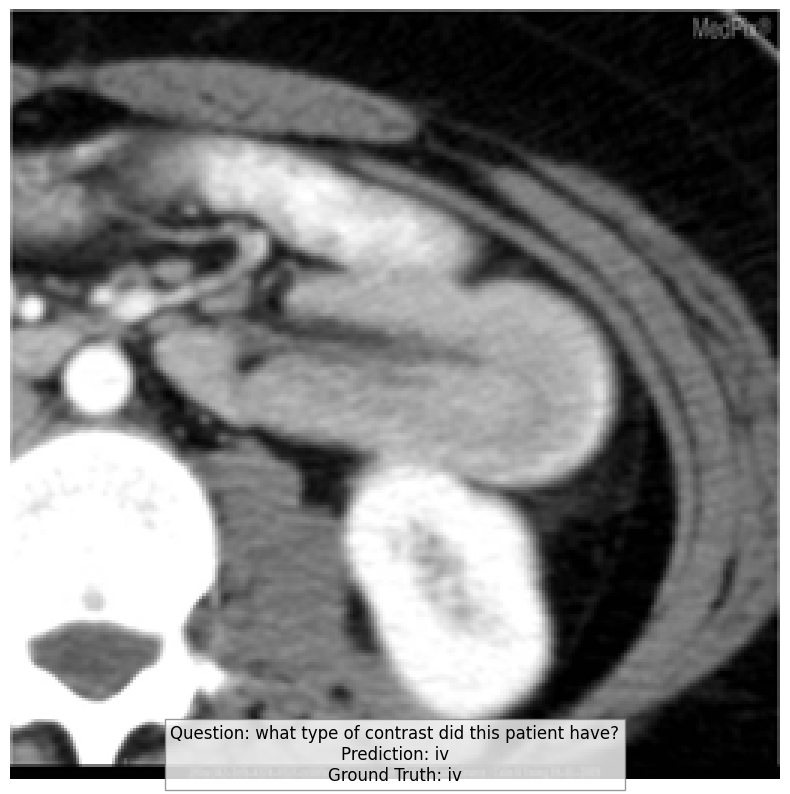

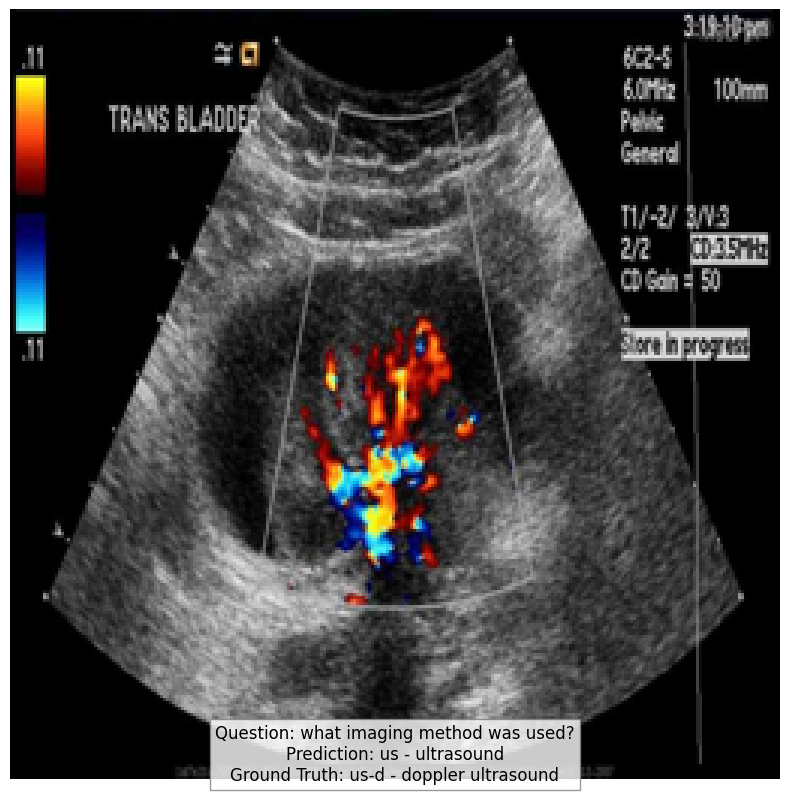

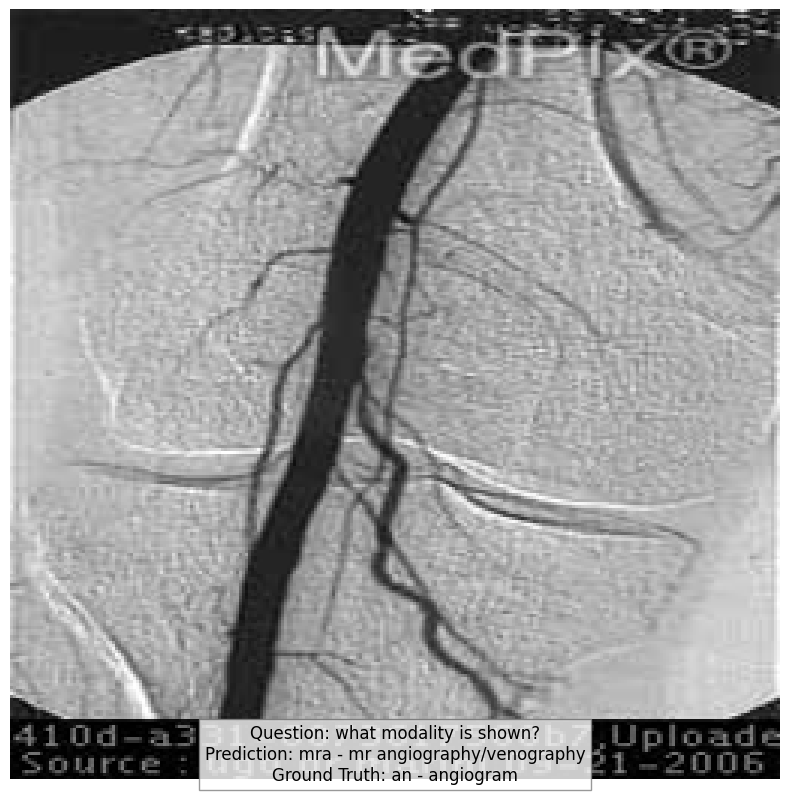

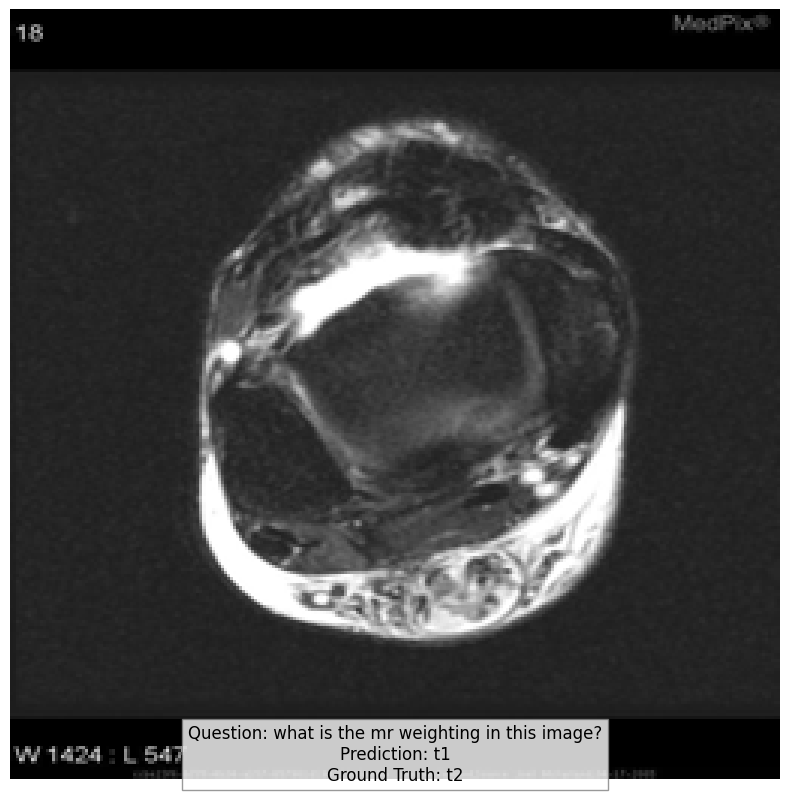

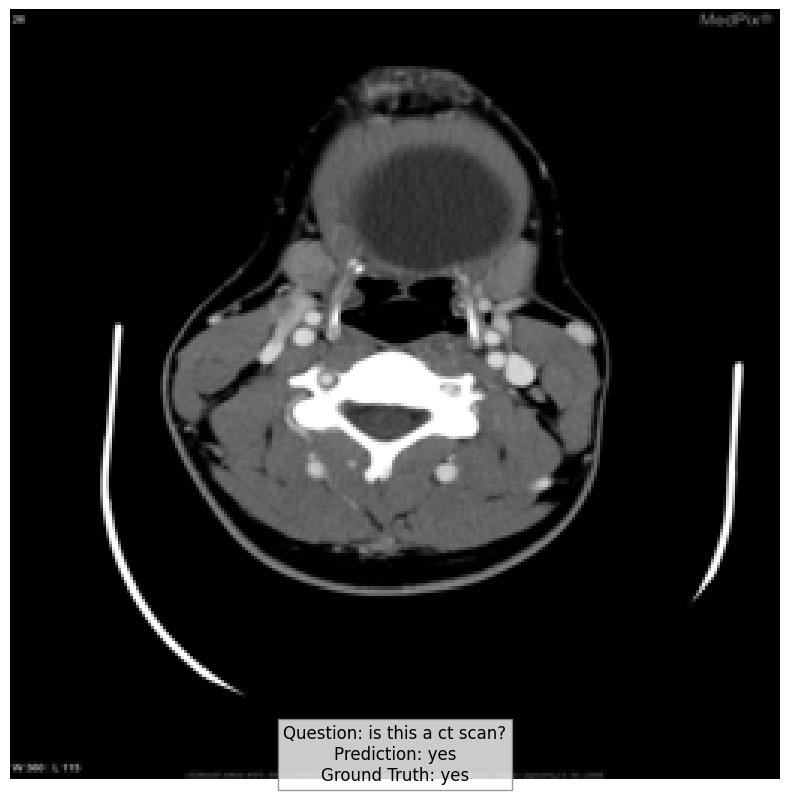

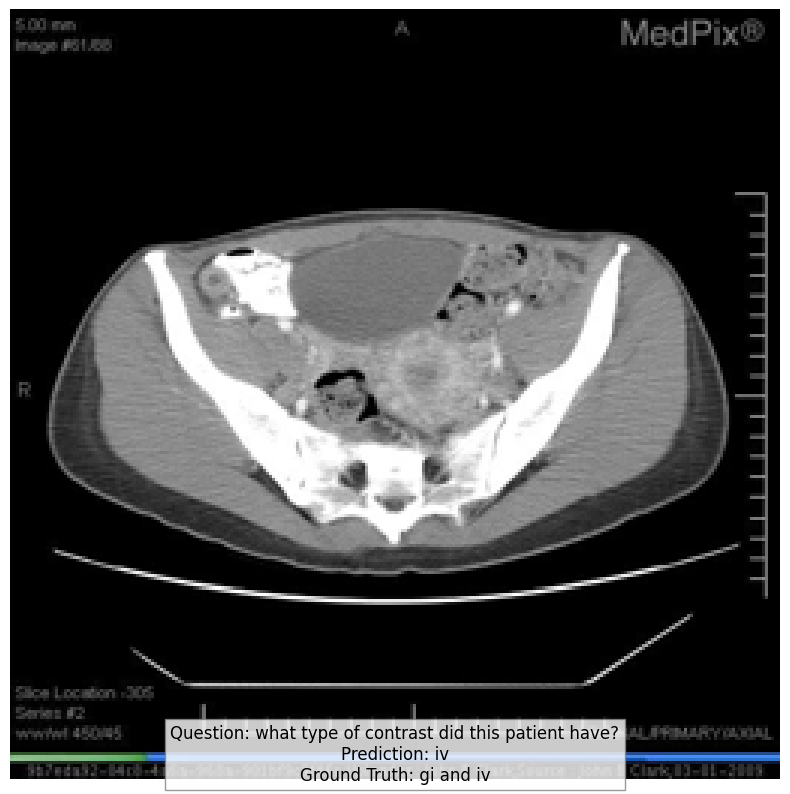

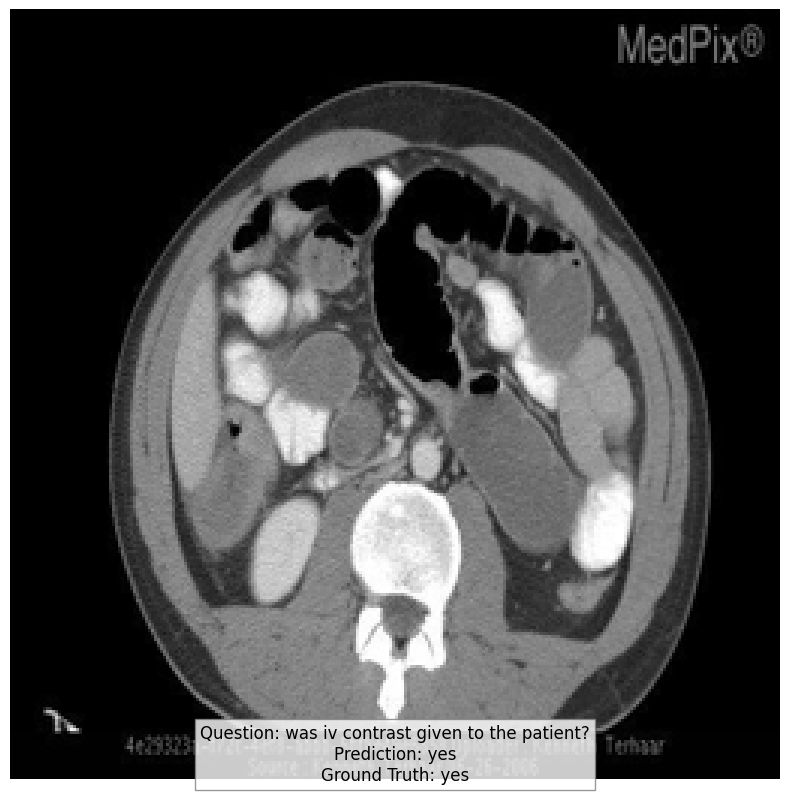

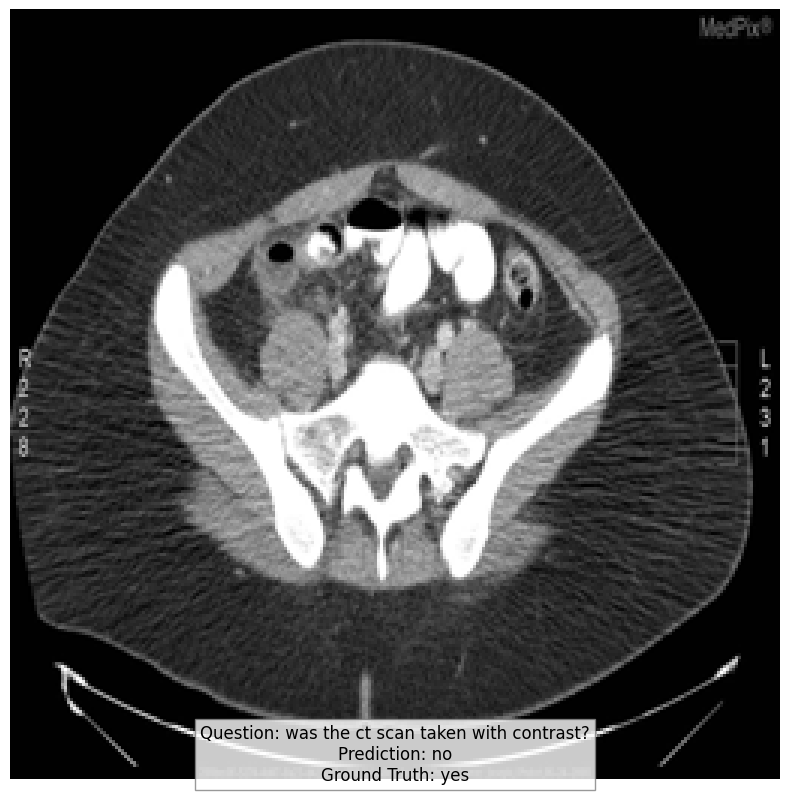

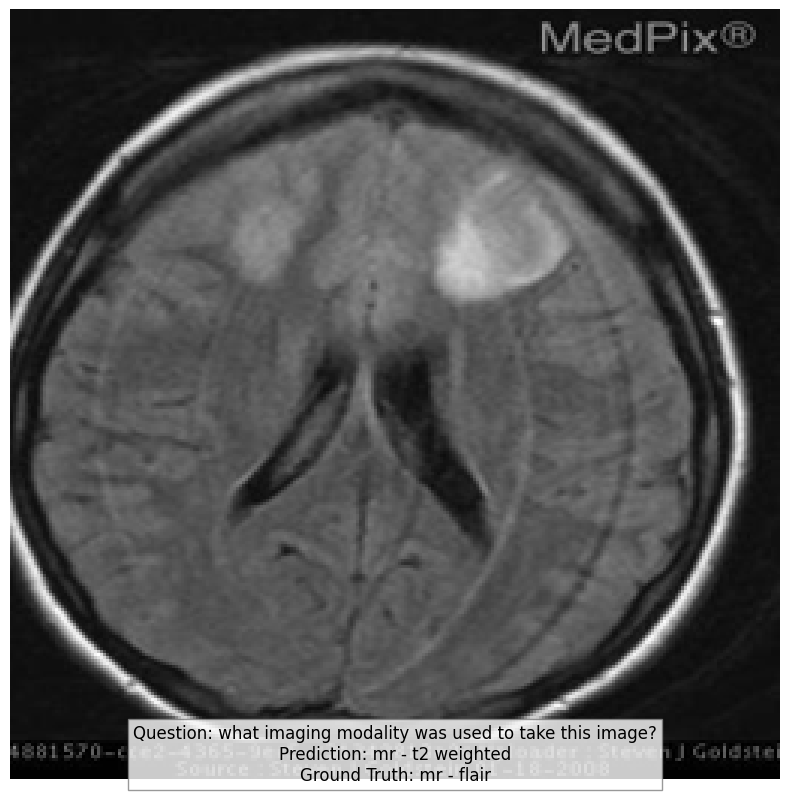

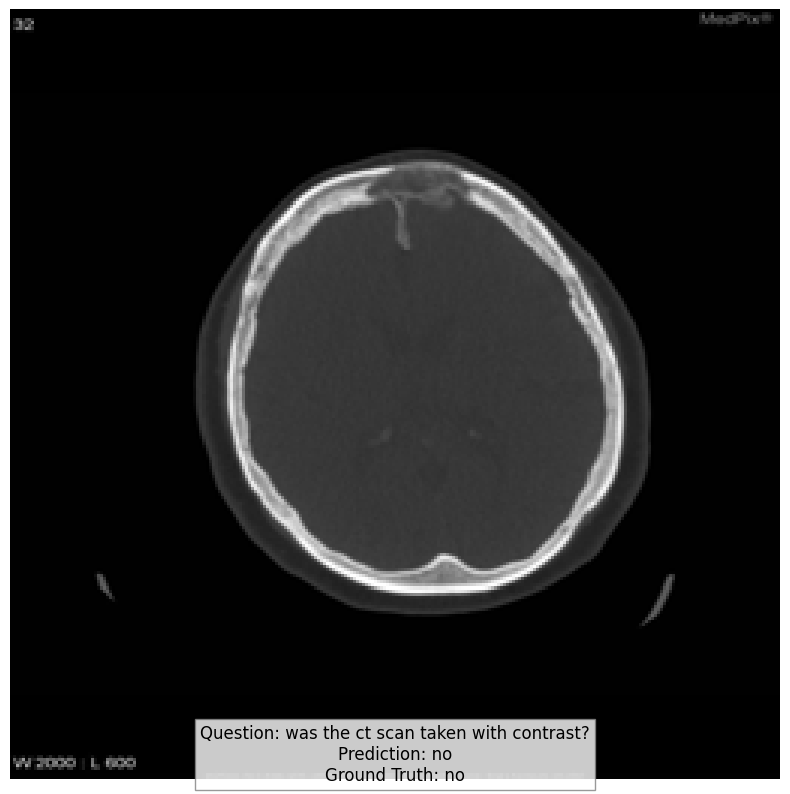

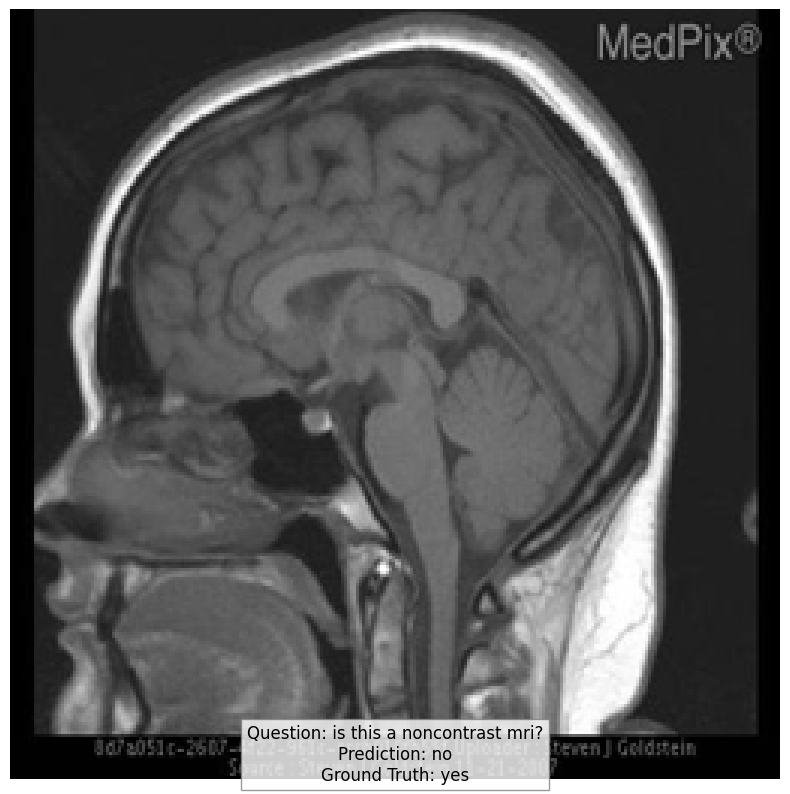

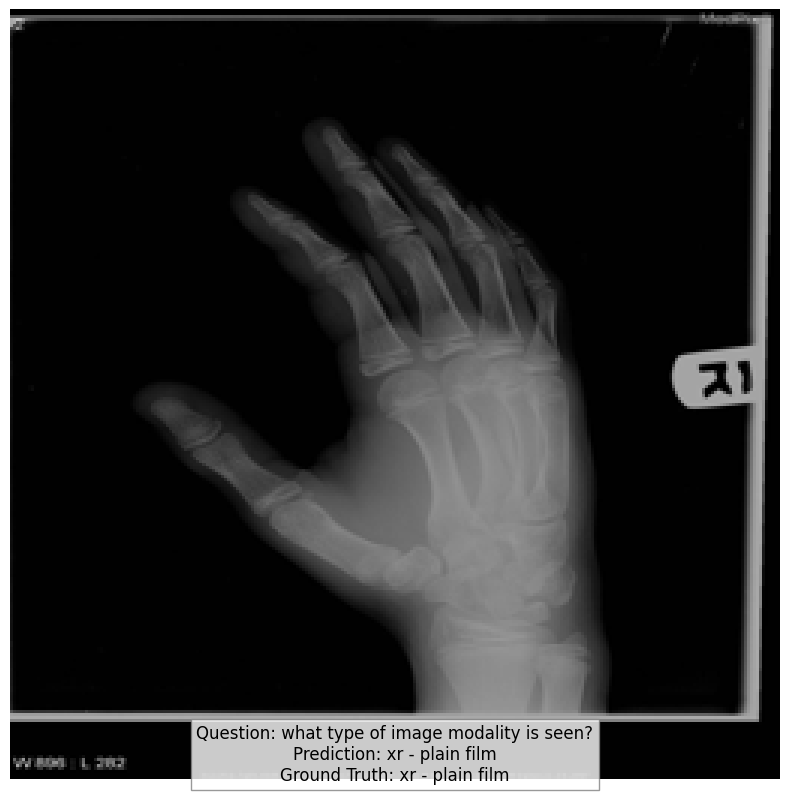

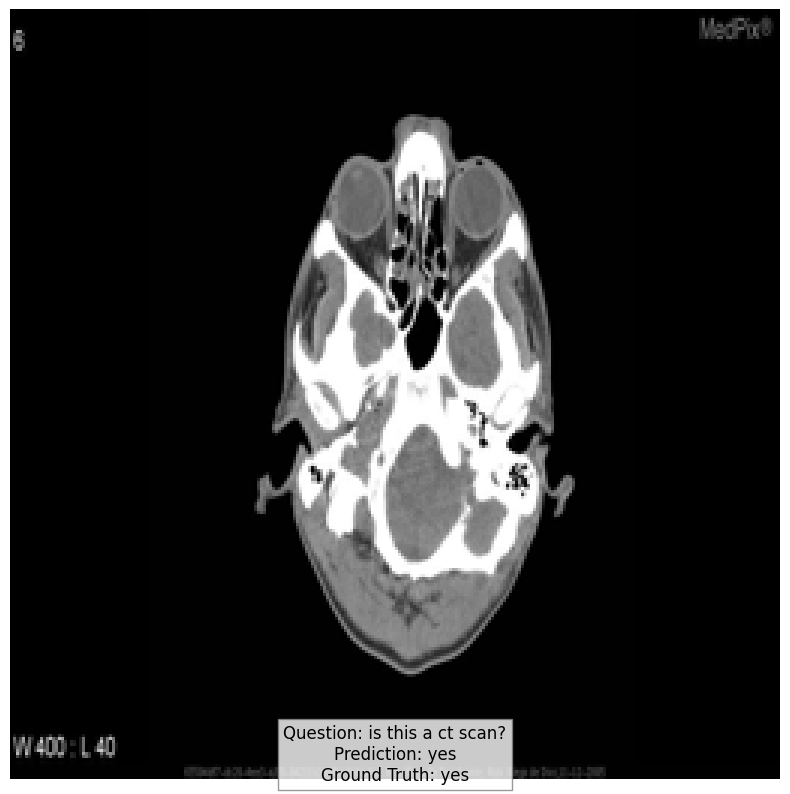

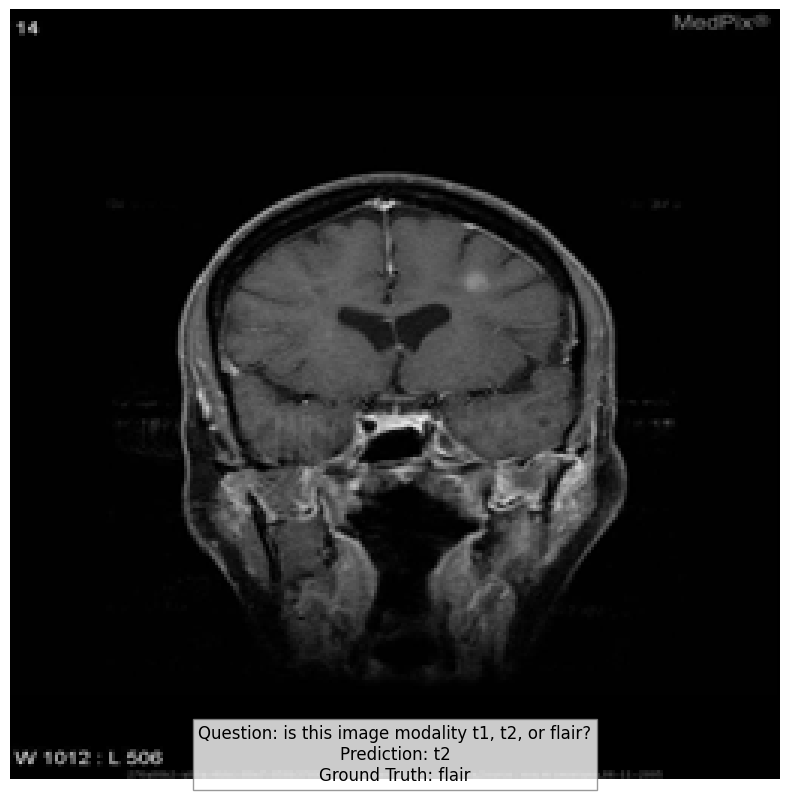

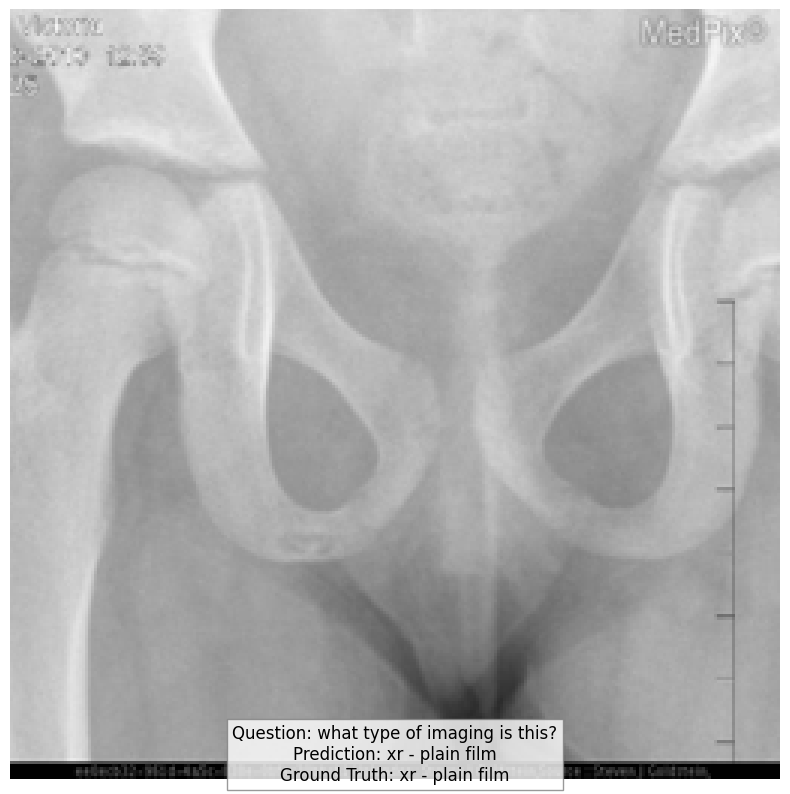

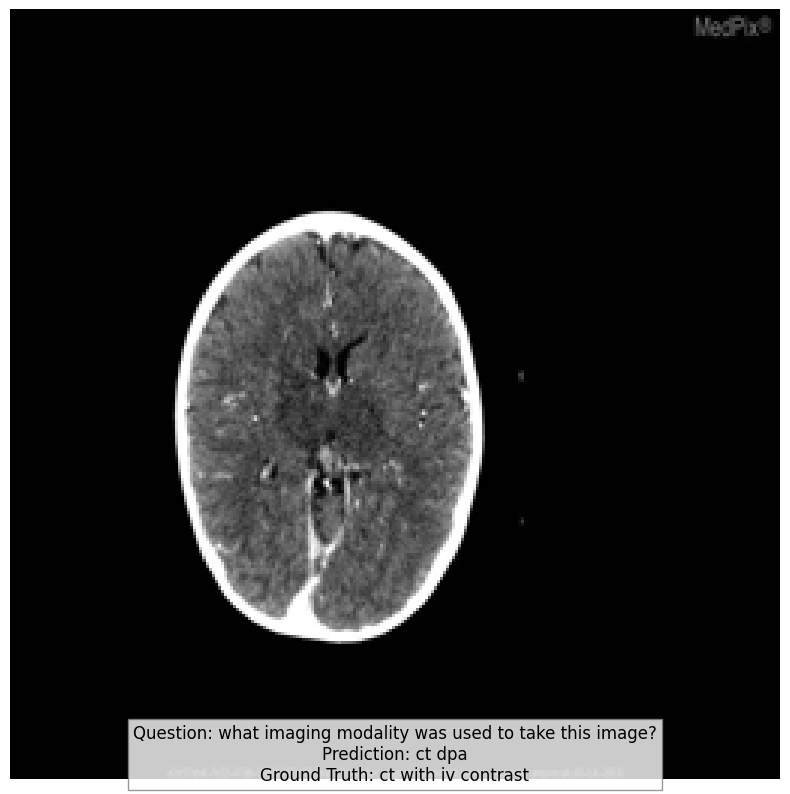

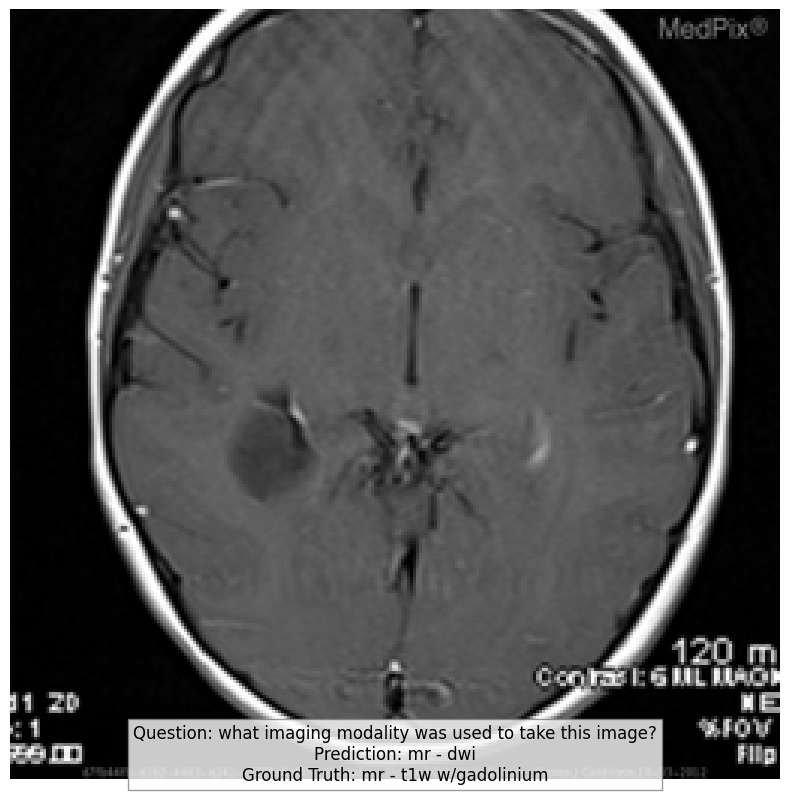

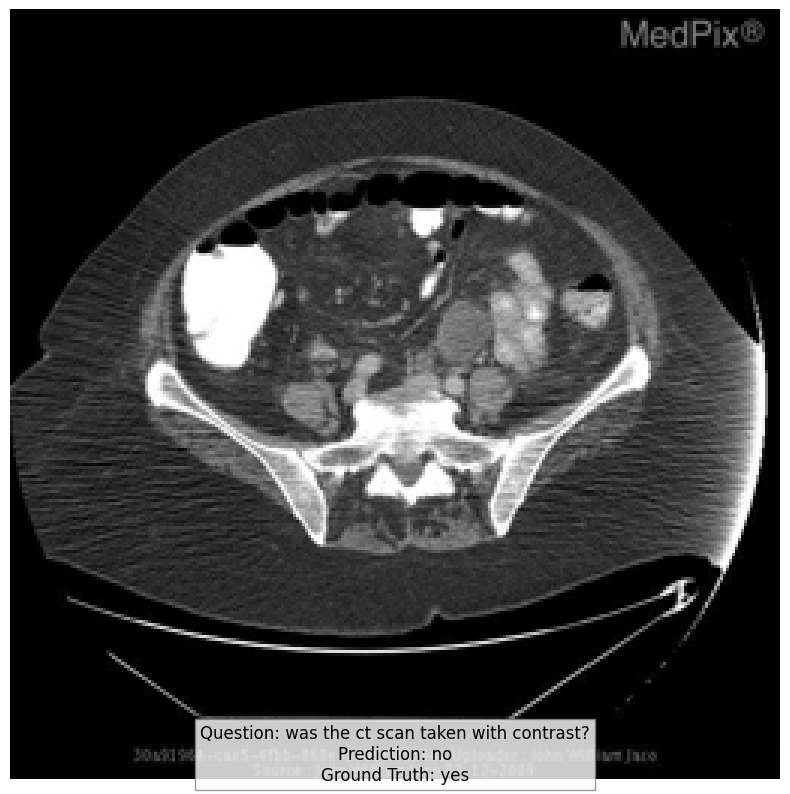

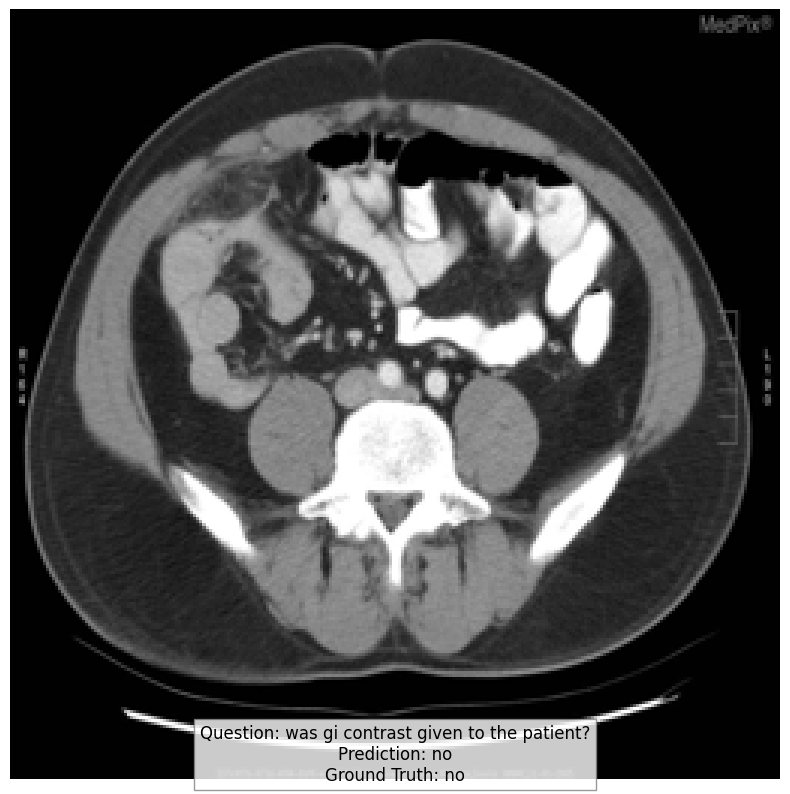

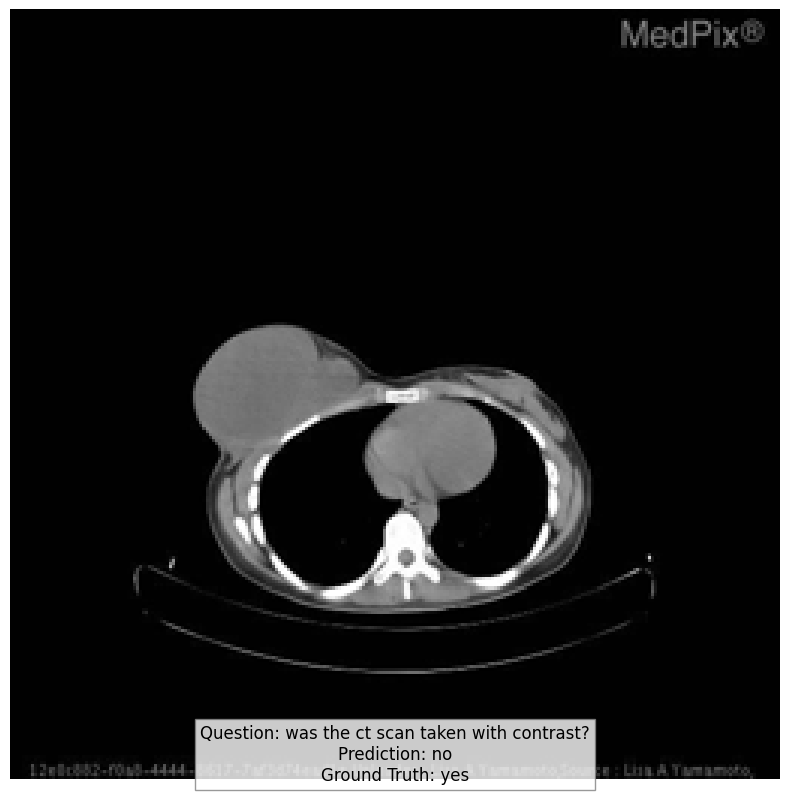

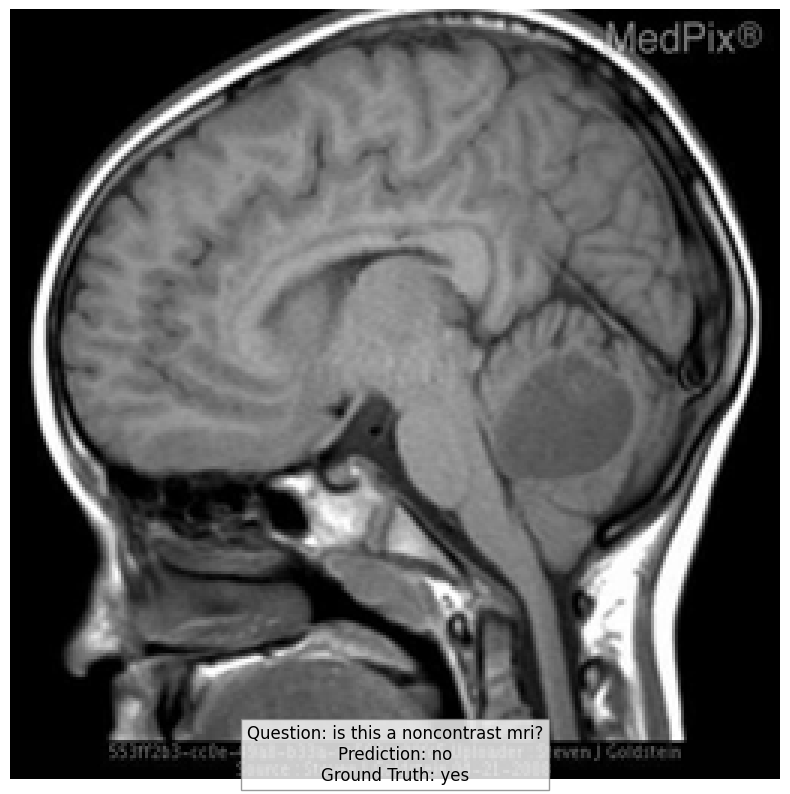

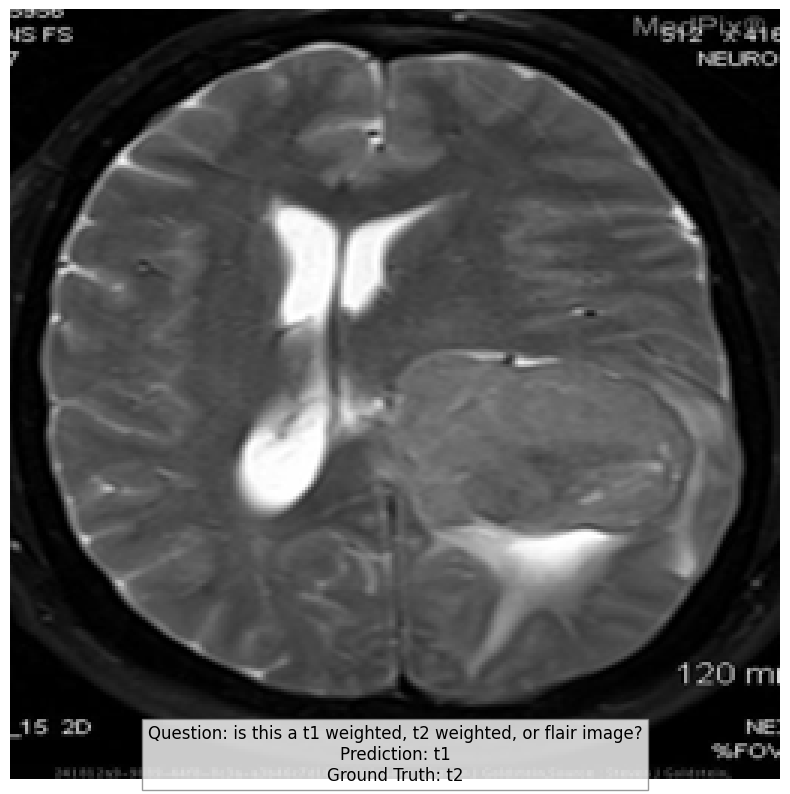

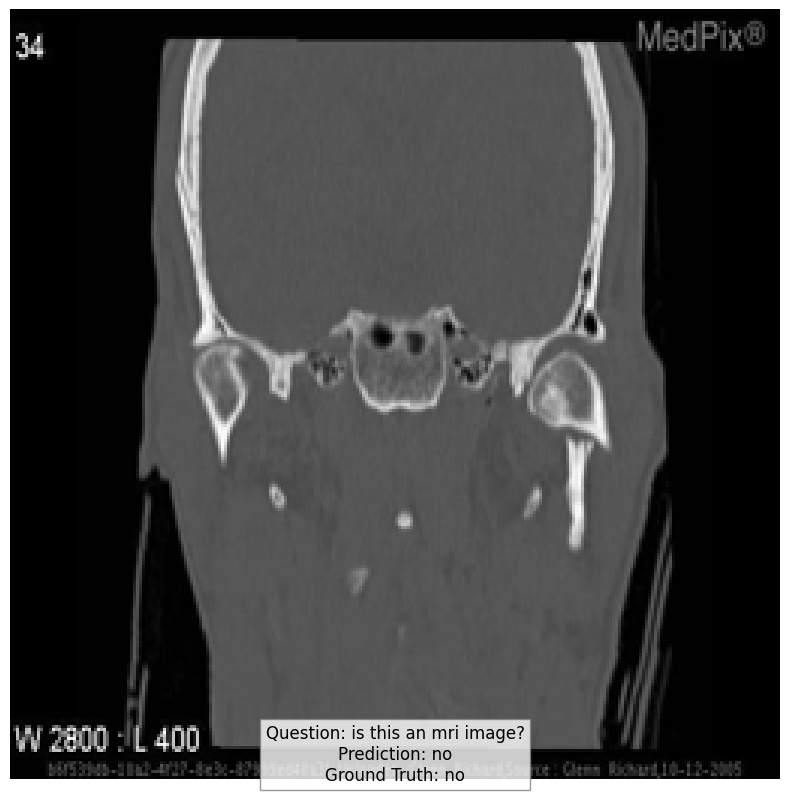

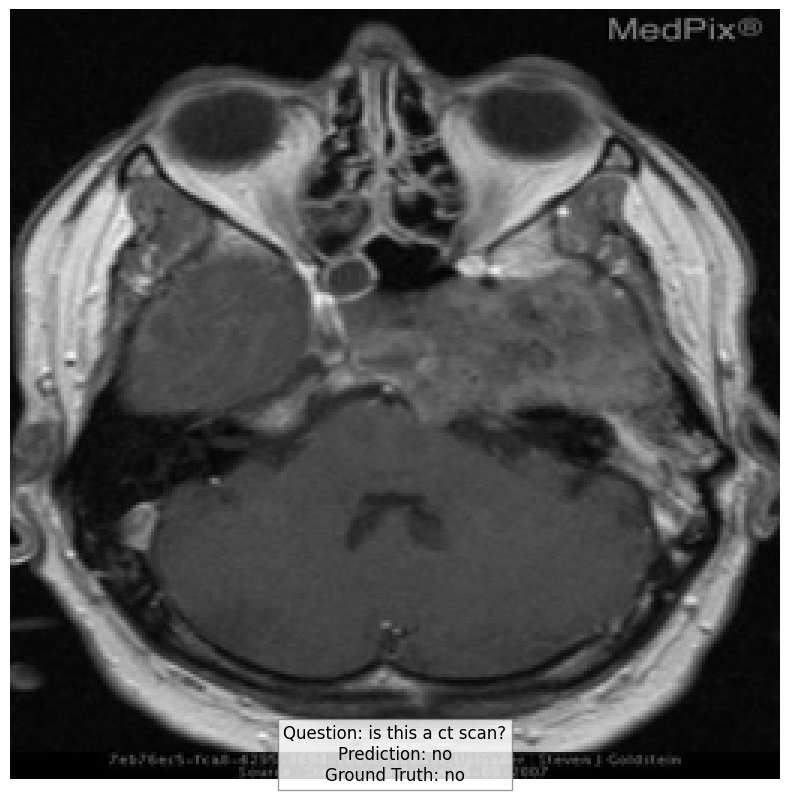

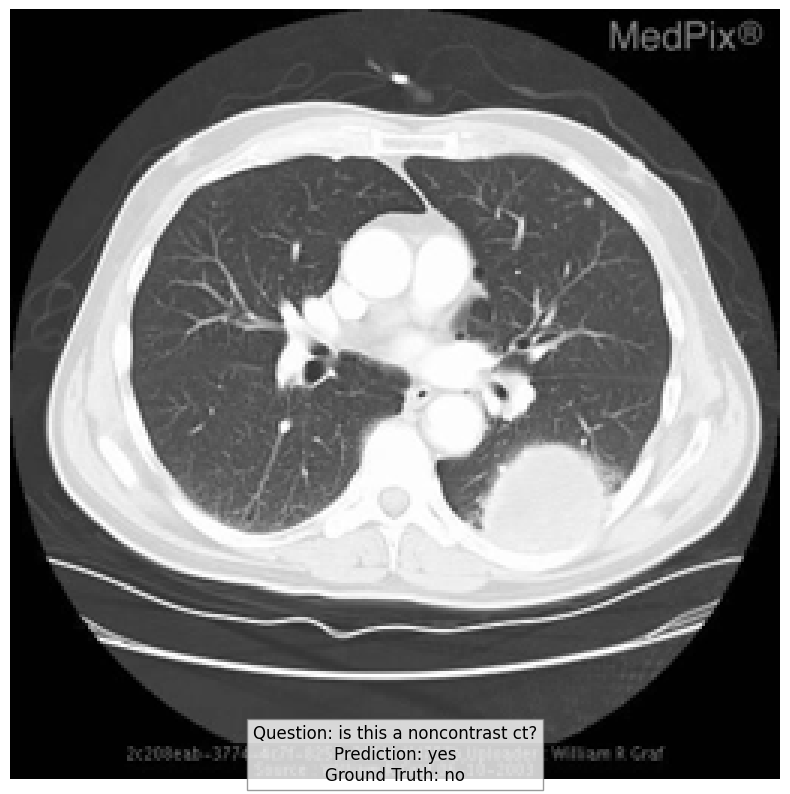

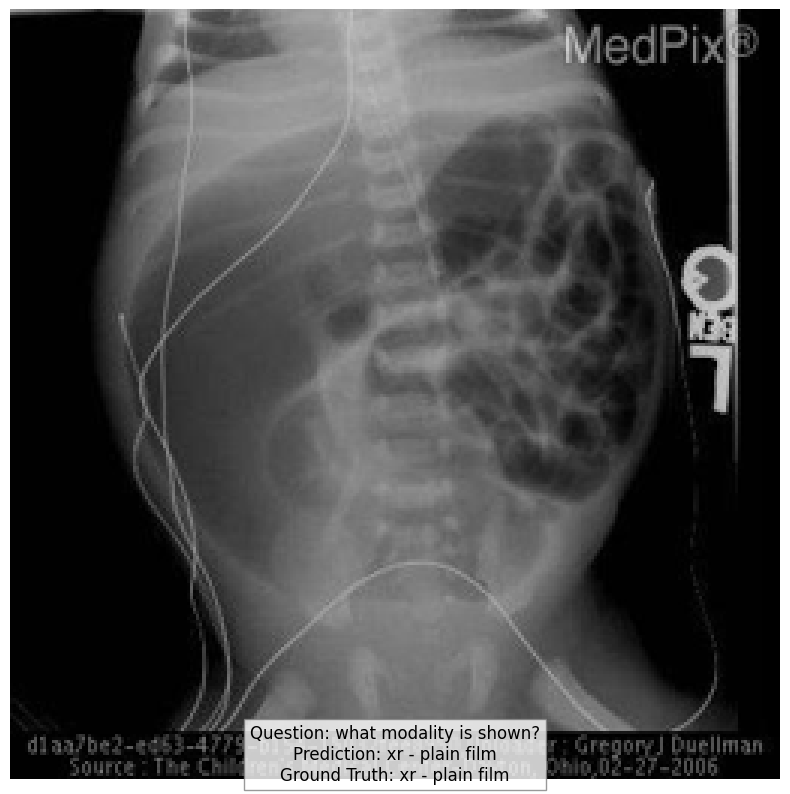

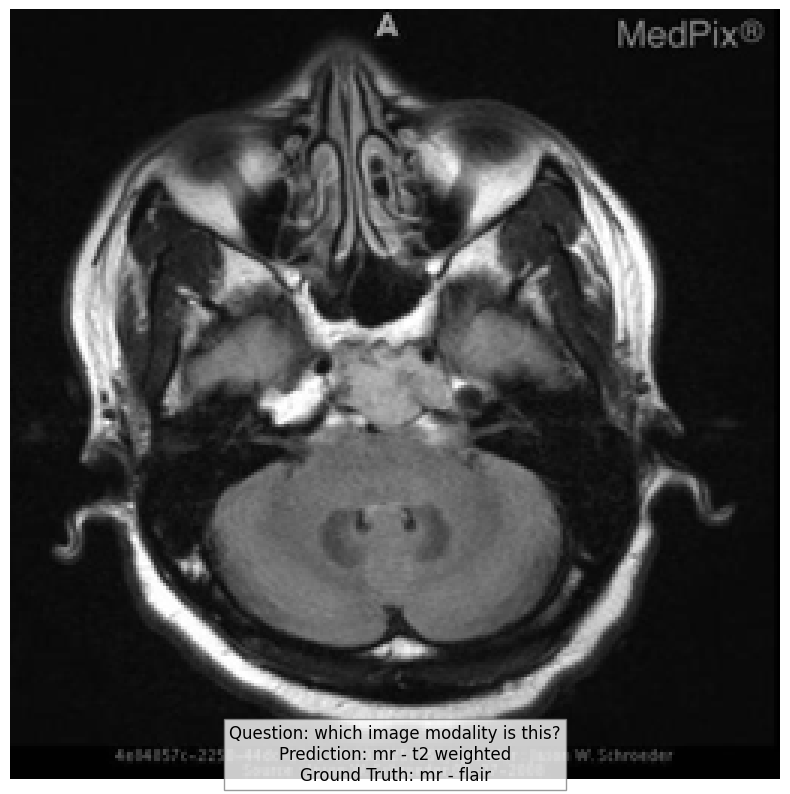

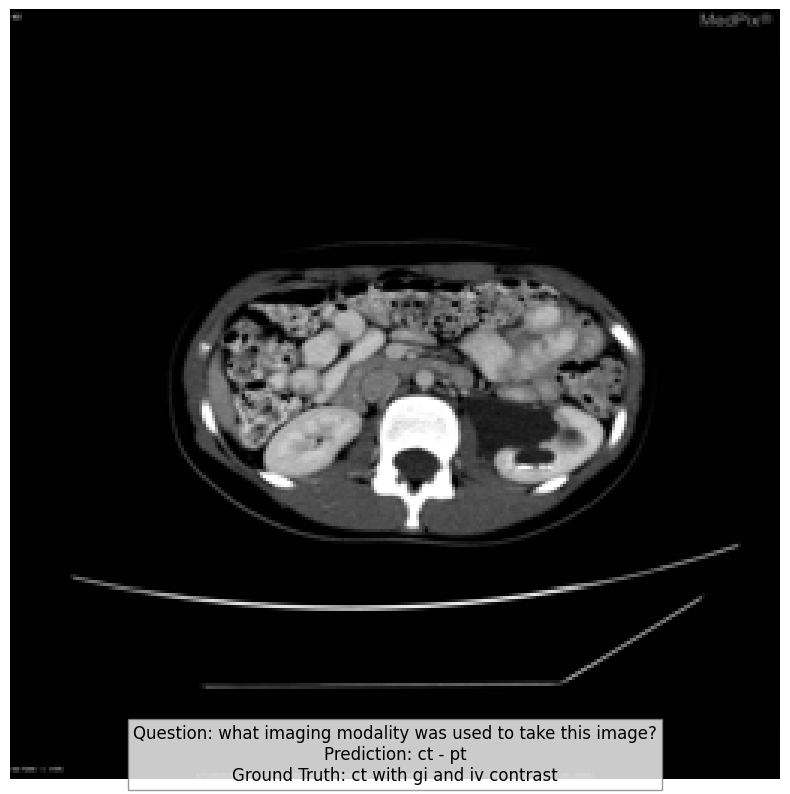

In [18]:
for selected_sample_idx in range(30):
  sample = test_dataset[selected_sample_idx]
  pred = qwen_vqa_prediction(qwen_model, processor, sample, device=device)

  visualize_vqa_sample(sample['image'], sample['question'], prediction=pred, ground_truth=sample['answers'][0])

## 3. Florence-V2 prediction